<a href="https://colab.research.google.com/github/lanyu0322/phd_semester1/blob/master/Model_Monitoring_Framework_Lan_Yu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard Libraries
import os
import time
import random
import pickle
import warnings
import psutil
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Models and Preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
# Model Evaluation and Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report
)
from sklearn.inspection import permutation_importance
from scipy.stats import ks_2samp

# Model Selection and Tuning
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    learning_curve
)

# Handling Imbalanced Data
from imblearn.over_sampling import RandomOverSampler

# Model Persistence
from joblib import dump, load

### Data Pre-processing

In [2]:
# load the data
colname = ['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'dep']
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv', names=colname)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   var1    768 non-null    int64  
 1   var2    768 non-null    int64  
 2   var3    768 non-null    int64  
 3   var4    768 non-null    int64  
 4   var5    768 non-null    int64  
 5   var6    768 non-null    float64
 6   var7    768 non-null    float64
 7   var8    768 non-null    int64  
 8   dep     768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.shape

(768, 9)

In [4]:
df.head()

,var1,var2,var3,var4,var5,var6,var7,var8,dep
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# Define features and target
X = df.drop('dep', axis=1)
y = df['dep']

# standardization
scaler = StandardScaler()

# fit the scaler on the training data and transform it
X_stan = scaler.fit_transform(X)

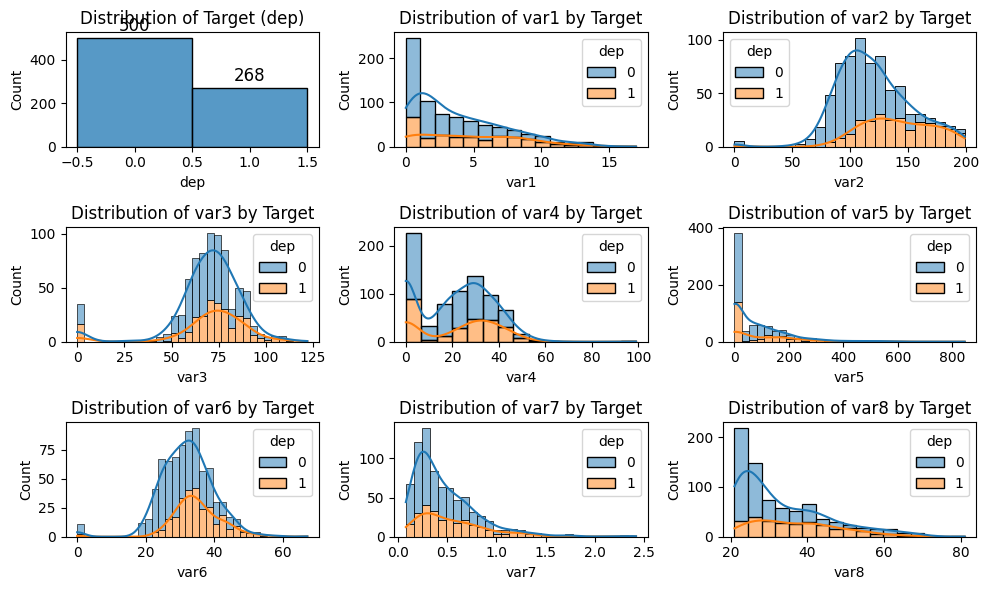

In [6]:
# Define the number of columns for the subplot grid
num_cols = 3
num_features = len(X.columns) + 1  # +1 for the target variable
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a figure and set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution of the target variable itself, with counts for each category
sns.histplot(data=df, x='dep', discrete=True, kde=False, ax=axes[0])
axes[0].set_title('Distribution of Target (dep)')
axes[0].set_ylabel('Count')

# Annotate counts on the target distribution plot
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                     textcoords='offset points')

# Plot each feature in a subplot with individual y-axis limits and bins
for i, column in enumerate(X.columns, start=1):  # Start from index 1 for the feature plots
    sns.histplot(data=df, x=column, hue='dep', multiple='stack', kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {column} by Target')
    axes[i].set_ylabel('Count')

# Remove any unused subplots
for i in range(num_features, len(axes)):
    fig.delaxes(axes[i])

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


## <font color="darkblue"> Balance the training data </font>

<font color="darkblue"> Usually, I prefer undersampling over oversampling to avoid potential risks and issues. However, I've already tried undersampling, and the performance wasn't satisfactory. Since I don't have more information about the data and it's not the primary goal of this task, let's temporarily proceed with oversampling for the following analysis

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_stan, y, test_size=0.2, random_state=131)

# Apply RandomOverSampler to the training set
rus = RandomOverSampler(random_state=131)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

### Model fitting

In [20]:
# Define the path where the models will be saved
gridsearch_model_path = "/content/drive/MyDrive/OA/best_gridsearch_model.joblib"
randomsearch_model_path = "/content/drive/MyDrive/OA/best_randomsearch_model.joblib"

# Check if GridSearch model exists
if os.path.exists(gridsearch_model_path):
    best_gridsearch_model = load(gridsearch_model_path)
    print("GridSearch model loaded.")
else:
    print(f"GridSearch model not found at {gridsearch_model_path}. Please generate the model.")

# Check if RandomizedSearch model exists
if os.path.exists(randomsearch_model_path):
    best_randomsearch_model = load(randomsearch_model_path)
    print("RandomizedSearch model loaded.")
else:
    print(f"RandomizedSearch model not found at {randomsearch_model_path}. Please generate the model.")

GridSearch model loaded.
RandomizedSearch model loaded.


## Create the model if it does not exist

<font color="darkblue"> Let's begin with a random search to identify a good set of parameters, and then proceed with a grid search using the best parameters identified from the random search. For your reference, the random search parameters have already been adjusted.</font>

In [9]:
# Define a balanced hyperparameter grid
param_dist = {
    'n_estimators': [50, 70, 100],  # Balances model robustness with training time
    'max_depth': [5, 10, 15],  # Prevents overfitting by limiting tree depth
    'min_samples_split': [20, 30, 40],  # Reduces risk of splitting on noise
    'min_samples_leaf': [10, 15, 20],  # Ensures sufficient samples per leaf for generalization
    'max_features': ['sqrt'],  # Standard choice for smaller datasets
    'criterion': ['gini'],  # Efficient for binary classification
    'bootstrap': [True],  # Introduces variability to prevent overfitting
}

# Initialize and perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=131),
                                                param_distributions=param_dist,
                                                n_iter=50, # Number of iterations for Random Search
                                                cv=5, # 5-fold cross-validation
                                                scoring='f1_macro', # Scoring metric to optimize
                                                random_state=131,
                                                n_jobs=-1,  # Use all available cores
                                                verbose=3,
                                                )

# Fit RandomizedSearchCV
random_search.fit(X_train_resampled, y_train_resampled)

# Evaluate on training and test sets
y_train_pred = random_search.best_estimator_.predict(X_train_resampled)
y_test_pred = random_search.best_estimator_.predict(X_test)

# Print best parameters
print("\nBest parameters found by Random Search:")
print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found by Random Search:
{'n_estimators': 100, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini', 'bootstrap': True}


In [10]:

# Training set evaluation
print("\nAccuracy on the training set:", accuracy_score(y_train_resampled, y_train_pred))
print("\nClassification Report on the training set:")
print(classification_report(y_train_resampled, y_train_pred))

# Test set evaluation
print("\nAccuracy on the test set:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report on the test set:")
print(classification_report(y_test, y_test_pred))


Accuracy on the training set: 0.860969387755102

Classification Report on the training set:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       392
           1       0.85      0.88      0.86       392

    accuracy                           0.86       784
   macro avg       0.86      0.86      0.86       784
weighted avg       0.86      0.86      0.86       784


Accuracy on the test set: 0.7597402597402597

Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       108
           1       0.58      0.70      0.63        46

    accuracy                           0.76       154
   macro avg       0.72      0.74      0.73       154
weighted avg       0.78      0.76      0.77       154



<font color="darkblue"> From the predicted results, we noticed there is an overfitting problem, particularly evident from the drop in performance on the test set (i.e., precision for class 1).

<font color="darkblue"> While there are several approaches to address overfitting and unbalanced precision, such as adjusting class weights, using regularization techniques, or employing more advanced methods like SMOTE for balancing, considering the goal of this case is to develop a monitoring plan, and without a data dictionary for deeper insights, we will stick with the current model.

To refine it further, we will apply a GridSearch to fine-tune the hyperparameters, aiming to improve overall performance and address the observed imbalance. </font>

  ## GridSearchCV after random search

In [14]:
# Refine the search space for GridSearchCV based on the best parameters from RandomizedSearchCV
grid_param_dist = {
    'n_estimators': [random_search.best_params_['n_estimators'] - 10,
                     random_search.best_params_['n_estimators'],
                     random_search.best_params_['n_estimators'] + 10],
    'max_depth': [random_search.best_params_['max_depth'] - 1,
                  random_search.best_params_['max_depth'],
                  random_search.best_params_['max_depth'] + 1],
    'min_samples_split': [random_search.best_params_['min_samples_split'] - 5 if random_search.best_params_['min_samples_split'] > 5 else 2,
                          random_search.best_params_['min_samples_split'],
                          random_search.best_params_['min_samples_split'] + 5],
    'min_samples_leaf': [random_search.best_params_['min_samples_leaf'] - 2 if random_search
                         .best_params_['min_samples_leaf'] > 1 else 1,
                         random_search.best_params_['min_samples_leaf'],
                         random_search.best_params_['min_samples_leaf'] + 2],
    'max_features': [random_search.best_params_['max_features']],  # Keep the best max_features
    'criterion': [random_search.best_params_['criterion']],  # Keep the best criterion
    'bootstrap': [random_search.best_params_['bootstrap']],  # Keep the best bootstrap
}

# Initialize and perform GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=131),
                           param_grid=grid_param_dist,
                           cv=5,
                           scoring='f1_macro',
                           n_jobs=-1,
                           verbose=3)

# Fit GridSearchCV
grid_search.fit(X_train_resampled, y_train_resampled)

# Evaluate on training and test sets
y_train_pred_grid = grid_search.best_estimator_.predict(X_train_resampled)
y_test_pred_grid = grid_search.best_estimator_.predict(X_test)

# Print best parameters
print("\nBest parameters found by Grid Search:")
print(grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters found by Grid Search:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 90}


In [15]:
# Training set evaluation
print("\nAccuracy on the training set:", accuracy_score(y_train_resampled, y_train_pred_grid))
print("\nClassification Report on the training set:")
print(classification_report(y_train_resampled, y_train_pred_grid))

# Test set evaluation
print("\nAccuracy on the test set:", accuracy_score(y_test, y_test_pred_grid))
print("\nClassification Report on the test set:")
print(classification_report(y_test, y_test_pred_grid))


Accuracy on the training set: 0.8788265306122449

Classification Report on the training set:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       392
           1       0.86      0.90      0.88       392

    accuracy                           0.88       784
   macro avg       0.88      0.88      0.88       784
weighted avg       0.88      0.88      0.88       784


Accuracy on the test set: 0.7662337662337663

Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.87      0.79      0.83       108
           1       0.59      0.72      0.65        46

    accuracy                           0.77       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.78      0.77      0.77       154



<font color="darkblue"> **Overfitting**: Both Grid Search and Random Search resulted in models with similar overfitting issues. However, Grid Search demonstrated improvements across all evaluation metrics (precision, recall, F1-score, accuracy).

<font color="darkblue"> **Conclusion**: Grid Search provides more efficient hyperparameter optimization with better performance on the test set. Let's stick with this model.

---



# Monitoring Plan Test Code (25 points)

<font color="darkblue"> Since future data isn't available, let's split the test data as a proxy for both training and future data, and visualize the results for easier interpretation.

In [22]:
X_expected, X_actual, y_expected, y_actual = train_test_split(X_train, y_train, test_size=0.5, random_state=21)

## Conceptual Soundness Monitoring

<font color="darkblue"> **Data Drift Detection**

<font color="darkblue"> Sicne Random Forest  is relatively assumption-free, monitoring data drift ensures that the input and output stability is maintained, which is crucial for consistent model predictions.

<font color="darkgreen"> **PSI and CSI**

In [184]:
#PSI and CSI Calculation Functions
def calculate_psi(expected, actual, bins=10):
    expected = np.array(expected)
    actual = np.array(actual)
    # Create breakpoints for the bins, ranging from the minimum to maximum of the expected values
    breakpoints = np.linspace(np.min(expected), np.max(expected), bins + 1)
    breakpoints = np.linspace(np.min(expected), np.max(expected), bins + 1)
    # Calculate the percentage of expected/actual values that fall into each bin
    expected_percents = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, bins=breakpoints)[0] / len(actual)
    # Small constant to avoid division by zero in logarithm calculation
    epsilon = 1e-10
    # Calculate PSI values for each bin
    psi_values = (expected_percents - actual_percents) * np.log((expected_percents + epsilon) / (actual_percents + epsilon))
    # Sum the PSI values across all bins to get the total PSI
    psi = np.sum(psi_values)
    return psi

def calculate_csi(expected, actual, bins=10):
    return calculate_psi(expected, actual, bins=bins)

# De-standardize the data
X_expected_destandardized = scaler.inverse_transform(X_expected)
X_actual_destandardized = scaler.inverse_transform(X_actual)

# Calculate PSI between training and future data for each feature
y_expected_prob = random_search.best_estimator_.predict_proba(X_expected)[:, 1]
y_actual_prob = random_search.best_estimator_.predict_proba(X_actual)[:, 1]

psi_value = calculate_psi(y_expected_prob, y_actual_prob)
print(f"PSI for 'Dep': {psi_value:.4f}")

# Get predicted probabilities for training and future data
for i in range(X.shape[1]):
    csi_value = calculate_csi(X_expected_destandardized[:, i], X_actual_destandardized[:, i])
    print(f"CSI for Var{i+1}: {csi_value:.4f}")

PSI for 'Dep': 0.0156
CSI for Var1: 0.0354
CSI for Var2: 0.0583
CSI for Var3: 0.2359
CSI for Var4: 0.1831
CSI for Var5: 0.0950
CSI for Var6: 0.2807
CSI for Var7: 0.3002
CSI for Var8: 0.0481


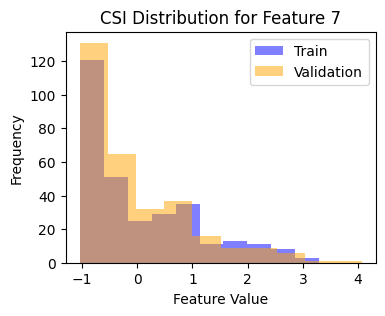

In [210]:
# Visualize the distributions of the highest CSI feature
plt.figure(figsize=(4, 3))
plt.hist(X_expected[:, 7], bins=10, alpha=0.5, label='Train', color='blue')
plt.hist(X_actual[:, 7], bins=10, alpha=0.5, label='Validation', color='orange')
plt.title("CSI Distribution for Feature 7")
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

*  <font color="darkblue">  PSI (Population Stability Index) and CSI (Characteristic Stability Index) are both metrics used to detect and quantify data drift, particularly in scenarios where you want to monitor the stability of a dataset or model over time. They help assess whether the distribution of certain features in your data has changed significantly between different time periods or between different datasets. Here, in my monitoring plan, I will first calculate the PSI. If PSI > 0.1, we will then check the CSI for each feature and explore further.
*  <font color="darkblue"> High PSI or CSI values suggest that the data distribution has changed (i.e., >0.25), potentially leading to a decline in model performance, which might require model retraining or adjustments.

---



<font color="darkgreen">**KS-score**

In [186]:
# Initialize a dictionary to store drifted features and their p-values
drifted_features = {}
no_drifted = {}

# Loop through each feature and perform the KS test
for i in range(X_expected.shape[1]):
    ks_statistic, p_value = ks_2samp(X_expected[:, i], X_actual[:, i])
    if p_value < 0.05:  # If p-value is low, there is a significant difference
        drifted_features[i] = p_value
    else:
        no_drifted[i] = p_value

# Check if there are any drifted features
if drifted_features:
    print("Drifted features detected:")
    for feature, p_val in drifted_features.items():
        print(f"Feature {feature}: p-value = {p_val:.4f}")
else:
    print("No data drift detected in any feature.")


No data drift detected in any feature.


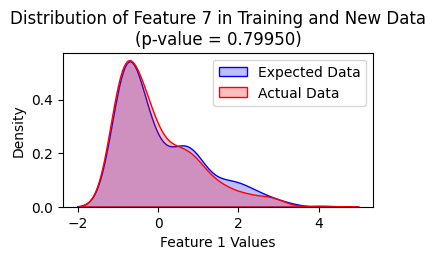

In [209]:
# -- visualization
plt.figure(figsize=(4, 2))
# Plot the distribution of the feature in the training and test datasets
sns.kdeplot(X_expected[:, 7], label='Expected Data', color='blue', fill=True)
sns.kdeplot(X_actual[:, 7], label='Actual Data', color='red', fill=True)

plt.title(f'Distribution of Feature {7} in Training and New Data\n(p-value = {no_drifted[6]:.5f})')
plt.xlabel(f'Feature {1} Values')
plt.ylabel('Density')
plt.legend()
plt.show()

<font color="darkblue"> The KS statistic measures the maximum deviation between empirical CDFs, capturing the most significant difference between distributions. A low p-value (e.g., < 0.05) indicates that the observed difference is unlikely to have occurred by chance, leading to the rejection of the null hypothesis and suggesting that data drift has likely occurred. Otherwise, the observed difference is statistically insignificant.

<font color="red"> Notice: If there is a small, consistent shift across many parts of the distribution, the CSI might be high, but the KS score could remain low if there is no single point of significant deviation, as observed in our CSI and KS score for Feature 7. Combining these two methods can help us better understand the drift problem in our dataset.

---



<font color="darkblue"> **Model Drift Detection**

<font color="darkgreen"> **AUC-ROC curve**

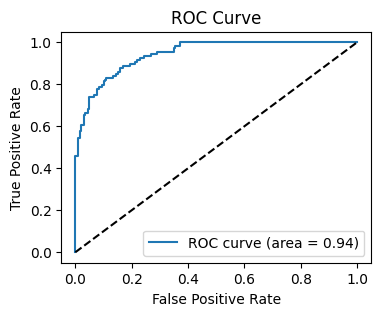

Optimal Threshold: 0.545


In [208]:
# Get prediction probabilities from the best estimator
y_probs_actual = grid_search.best_estimator_.predict_proba(X_actual)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_actual, y_probs_actual)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Optimal threshold based on Youden's J statistic (maximizing TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

# Use the optimal threshold to make predictions
y_pred_optimal = (y_probs_actual >= optimal_threshold).astype(int)



<font color="darkblue"> The ROC AUC is a powerful metric that provides **a broad measure of a model's ability to distinguish between positive and negative classes across all possible thresholds**.
It is particularly valuable for assessing overall model quality and is **especially effective in scenarios involving imbalanced datasets**, where traditional metrics like accuracy might be misleading. ROC AUC is also a critical tool for detecting model drift; any decline in the AUC score over time can indicate that the model's ability to discriminate between classes is deteriorating, signaling that the model may no longer be as effective as it once was.

---



<font color="darkgreen">**KS score**

In [201]:
# Separate predicted probabilities into the positive and negative classes
pos_probs = y_probs_actual[y_actual == 1]
neg_probs = y_probs_actual[y_actual == 0]

# Calculate KS statistic and p-value
ks_statistic, p_value = ks_2samp(pos_probs, neg_probs)
ks_statistic

print(f"KS Statistic: {ks_statistic:.4f}")

KS Statistic: 0.7218


<font color="darkblue"> **Kolmogorov-Smirnov (KS) score** is a way of comparing the cumulative sum of the positive and negative classes. It measures the maximum difference between the two over the range of predicted probabilities.


<font color="darkblue"> A high KS score indicates that the model has a better separation between the positive (goods) and negative classes (bads) at the respective tier. This metric is used widely in the finance and credit risk industry.

---



<font color="darkgreen"> **Classification report**

In [191]:
y_actual_pred = best_gridsearch_model.predict(X_actual)

# Test set evaluation
print("\nAccuracy on the test set:", accuracy_score(y_actual, y_actual_pred))
print("\nClassification Report on the test set:")
print(classification_report(y_actual, y_actual_pred))


Accuracy on the test set: 0.8469055374592834

Classification Report on the test set:
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       200
           1       0.74      0.86      0.80       107

    accuracy                           0.85       307
   macro avg       0.83      0.85      0.84       307
weighted avg       0.86      0.85      0.85       307



<font color="darkblue">The Classification Report offers a detailed breakdown of model performance at a specific threshold, including metrics such as precision, recall, F1-score, and accuracy. This report is essential for understanding how well a model performs in practical, threshold-dependent scenarios, particularly when decisions are made based on specific metrics.

<font color="darkblue">While it may be more sensitive to imbalances in the data, the Classification Report provides crucial insights into class-specific performance. Monitoring changes in these metrics over time is also a key method for detecting model drift, as shifts in precision, recall, or F1-score can indicate that the model's predictive power is waning at the chosen threshold.


**<font color="darkblue"> Combined with the AUC ROC curve, and KS score, they provide a comprehensive evaluation, enabling you to grasp the model's overall potential and fine-tune it for specific decision-making scenarios.**

---



<font color="red">Now, if we find that the performance metrics above have abnormally low values or if we want to redevelop our model after a year of deployment with future data, here are the methods we can apply. Keep in mind that the real situation may vary case by case

<font color="darkgreen"> **Reasses Feature Importance - ensure that the key features driving predictions are still relevant**

Text(0.5, 1.0, 'Comparison of Feature Importance')

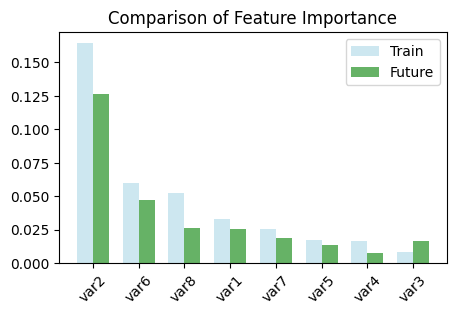

In [24]:
# Calculate and sort feature importance for training and validation data
train_importance = permutation_importance(grid_search.best_estimator_, X_expected, y_expected, n_repeats=10, random_state=131).importances_mean
actual_importance = permutation_importance(grid_search.best_estimator_, X_actual, y_actual, n_repeats=10, random_state=131).importances_mean

# descending sort
sorted_idx = np.argsort(-train_importance)


# Comparison plot
plt.figure(figsize=(5, 3))
plt.bar(np.arange(len(train_importance)) - 0.35/2, train_importance[sorted_idx], width=0.35, label='Train', color='lightblue', alpha=0.6)
plt.bar(np.arange(len(train_importance)) + 0.35/2, actual_importance[sorted_idx], width=0.35, label='Future', color='green', alpha=0.6)
plt.xticks(np.arange(len(train_importance)), np.array(colname[:-1])[sorted_idx], rotation=45)
plt.legend()
plt.title("Comparison of Feature Importance")

<font color="darkblue">**Summary: when variables are highly correlated, the feature importance rankings may become less stable, potentially leading to variability in the importance assigned to different features.**

<font color="darkblue">Domain Knowledge Evaluation: If the model assigns high importance to a feature that domain experts consider irrelevant, this could indicate an issue with the data or underlying model assumptions.


---




<font color="darkgreen">**Threshold Sensitivity**

Optimal Threshold: 0.50
Precision: 0.7984, Recall: 0.8609, F1-Score: 0.8285


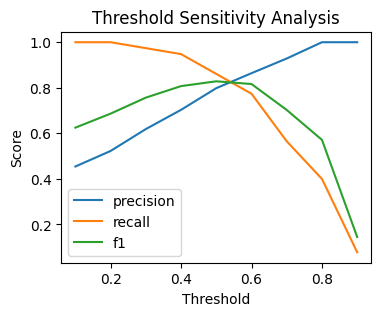

In [25]:
# Function to analyze threshold sensitivity and find the optimal threshold
def threshold_sensitivity_analysis(model, X, y, thresholds):
    metrics = []
    for threshold in thresholds:
        y_pred = (model.predict_proba(X)[:, 1] >= threshold).astype(int)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        metrics.append({'threshold': threshold, 'precision': precision, 'recall': recall, 'f1': f1})
    return metrics

#  with future data
thresholds = np.arange(0.1, 1.0, 0.1)
threshold_metrics = threshold_sensitivity_analysis(grid_search.best_estimator_, X_actual, y_actual, thresholds)

# Find the threshold with the highest F1-score
optimal_metric = max(threshold_metrics, key=lambda x: x['f1'])

# show it
print(f"Optimal Threshold: {optimal_metric['threshold']:.2f}")
print(f"Precision: {optimal_metric['precision']:.4f}, Recall: {optimal_metric['recall']:.4f}, F1-Score: {optimal_metric['f1']:.4f}")

# Plot the threshold sensitivity analysis results
plt.figure(figsize=(4, 3))
for metric in ['precision', 'recall', 'f1']:
    plt.plot(thresholds, [m[metric] for m in threshold_metrics], label=metric)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sensitivity Analysis')
plt.legend()
plt.show()

<font color="darkblue">**Detecting Performance Shifts:** After a model has been deployed for a year, the underlying data distribution may change, leading to performance degradation. A threshold sensitivity test helps identify how these changes affect the model’s performance at various thresholds. If the model’s performance drops sharply at certain thresholds, it could indicate that the model is no longer well-calibrated to the current data, signaling the need for retraining or redevelopment.

<font color="darkblue">Additionally, this method is also effective in **evaluating Stability Across Thresholds and Optimizing for Business Objectives** when redeveloping the model.

---



<font color="darkgreen">**Hyperparameter Sensitivity: with an alternative set of parameters**

In [214]:
def hyperparameter_sensitivity_analysis(X_train, y_train, best_params):
    # Define a grid around the best hyperparameters
    param_grid = {
        'n_estimators': [best_params['n_estimators'] - 10, best_params['n_estimators'], best_params['n_estimators'] + 10],
        'max_depth': [best_params['max_depth'] - 1, best_params['max_depth'], best_params['max_depth'] + 1],
        'min_samples_split': [best_params['min_samples_split'] - 5, best_params['min_samples_split'] + 5],
        'min_samples_leaf': [best_params['min_samples_leaf'] - 2, best_params['min_samples_leaf'] + 2],
        'max_features': [best_params['max_features']],
        'criterion': [best_params['criterion']],
        'bootstrap': [best_params['bootstrap']]
    }

    # Perform GridSearchCV to evaluate the impact of these variations
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=131),
                               param_grid=param_grid,
                               cv=5,
                               scoring='f1_macro',
                               n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_score_

# Just use F1 score as an example, we can use other metrics (precision, recall, accuracy, KS) as needed
best_params = grid_search.best_params_
hyperparameter_sensitivity_score = hyperparameter_sensitivity_analysis(X_actual, y_actual, best_params)
print(f"Best F1 Score from Hyperparameter Sensitivity Analysis: {hyperparameter_sensitivity_score:.4f}")


Best F1 Score from Hyperparameter Sensitivity Analysis: 0.7242


<font color="darkblue">Hyperparameter sensitivity analysis is essential when redeveloping a model after performance degradation or updating it with new data, as the optimal hyperparameter settings may have shifted. Identifying these optimal settings ensures that the model performs at its best.

---



<font color="darkgreen">**Feature Dropping**

In [219]:
key_features = colname[:-1]

# Function to drop a feature, re-train the model, and evaluate performance
def drop_feature_and_evaluate(model, X_train, y_train, X_test, y_test, feature_to_drop):
    X_train_dropped = X_train.drop(columns=[feature_to_drop])
    X_test_dropped = X_test.drop(columns=[feature_to_drop])

    # Re-train the model
    model.fit(X_train_dropped, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test_dropped)
    y_proba = model.predict_proba(X_test_dropped)[:, 1]
    performance_metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba)
    }
    return performance_metrics

# Scenario analysis: Drop each key feature and compare model performance
results = {}
for feature in key_features:
    metrics = drop_feature_and_evaluate(grid_search.best_estimator_, pd.DataFrame(X_train_resampled, columns=key_features),
                                        y_train_resampled, pd.DataFrame(X_test, columns=key_features),
                                        y_test, feature)
    results[feature] = metrics

# Display the results
results_df = pd.DataFrame(results).T  # Transpose for better readability
print(results_df)

      accuracy  precision    recall  f1_score   roc_auc
var1  0.766234   0.586207  0.739130  0.653846  0.846216
var2  0.649351   0.442857  0.673913  0.534483  0.708132
var3  0.766234   0.596154  0.673913  0.632653  0.830113
var4  0.753247   0.574074  0.673913  0.620000  0.833535
var5  0.707792   0.508197  0.673913  0.579439  0.820853
var6  0.759740   0.584906  0.673913  0.626263  0.815620
var7  0.766234   0.592593  0.695652  0.640000  0.836957
var8  0.753247   0.568966  0.717391  0.634615  0.795491


<font color="darkblue"> Feature dropping is a valuable method when redeveloping a model after detecting performance issues or updating it with new data. It helps identify and eliminate redundant features, improve model stability and interpretability, and prevent overfitting, ensuring that the redeveloped model is more robust, efficient, and better suited to current data. This process, combined with other methods like hyperparameter sensitivity analysis, ensures that the model continues to perform optimally in evolving data environments.

---



<font color="darkgreen"> **Benchmark model Analysis**

In [230]:
# Train Logistic Regression Model
logistic_model = LogisticRegression(random_state=42, solver='liblinear')
logistic_model.fit(X_train_resampled, y_train_resampled)

# Predict probabilities for the positive class
y_proba_logistic = logistic_model.predict_proba(X_actual)[:, 1]

# Compute ROC curve and AUC for Logistic Regression
fpr_logistic, tpr_logistic, _ = roc_curve(y_actual, y_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Additional Performance Metrics
y_pred_logistic = logistic_model.predict(X_actual)

print("\nLogistic Regression Performance:")
print(f"Precision: {precision_score(y_actual, y_pred_logistic):.4f}")
print(f"Recall: {recall_score(y_actual, y_pred_logistic):.4f}")
print(f"F1-Score: {f1_score(y_actual, y_pred_logistic):.4f}")


Logistic Regression Performance:
Precision: 0.6480
Recall: 0.7570
F1-Score: 0.6983


<font color="darkblue"> **Performance Reference:** A benchmark model provides a baseline against which the performance of more complex models can be compared. This baseline helps determine whether the more sophisticated model truly offers an improvement over a simpler approach.

<font color="darkblue"> **Change Detection**: By continuously comparing the performance of your deployed model against the benchmark, you can detect model drift.

<font color="darkblue"> **Evaluation of Enhancements**: Whenever changes are made to the model—such as hyperparameter tuning, feature engineering, or the introduction of new data—the benchmark model provides a reference point to evaluate whether these modifications lead to actual performance improvements.

---



#### Implementation & Deployment

<font color="darkgreen"> **Latency**

In [237]:
# Perform latency check
latencies = []
for sample in X_actual:
    start_time = time.time()  # Record the start time
    # Reshape the sample to be 2D
    sample = sample.reshape(1, -1)

    # Make a prediction (replace with your actual model inference code)
    prediction = grid_search.best_estimator_.predict(sample)

    end_time = time.time()  # Record the end time

    # Calculate latency
    latency = end_time - start_time
    latencies.append(latency)

# Calculate average latency
average_latency = np.mean(latencies)
max_latency = np.max(latencies)
min_latency = np.min(latencies)

print(f"Average Latency: {average_latency:.6f} seconds")
print(f"Maximum Latency: {max_latency:.6f} seconds")
print(f"Minimum Latency: {min_latency:.6f} seconds")

Average Latency: 0.021318 seconds
Maximum Latency: 0.088682 seconds
Minimum Latency: 0.007579 seconds


<font color="darkblue">Latency checks are beneficial for enhancing user experience, facilitating effective scaling, enabling early issue detection, optimizing resource usage, and maintaining system reliability and efficiency.

---



<font color="darkgreen">**Threshold Alerts**

In [241]:
# Example of performance monitoring in code
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='macro')

# Let's set accuracy_threshold, f1_threshold, and cpu_threshold manually
accuracy_threshold = 0.61
f1_threshold = 0.6
cpu_threshold = 80.0

# Monitor current CPU usage
cpu_usage = psutil.cpu_percent(interval=1)

if cpu_usage > cpu_threshold:
    print(f"ALERT: CPU usage is high at {cpu_usage}%!")

# Alert if performance drops below thresholds
if accuracy < accuracy_threshold or f1 < f1_threshold:
    print("ALERT: Model performance has dropped below acceptable thresholds!")


<font color="darkblue">Threshold detection, not only for evaluation metrics but also for CPU, memory, and resource usage, is beneficial in the following ways: early detection of performance issues, ensuring model stability, responding quickly to data drift, supporting continuous model improvement, minimizing business impact, managing resources efficiently, and enabling automated responses.

---



<font color="darkgreen">**Business Metrics Monitoring**

In [245]:
# Sample DataFrame with revenue, CTR, and churn rate over different time periods
data = {
    'time_period': ['2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4'],
    'revenue': [10000, 12000, 11500, 9000],
    'click_through_rate': [0.05, 0.06, 0.055, 0.045],
    'churn_rate': [0.10, 0.09, 0.11, 0.13]
}

df = pd.DataFrame(data)

# Calculate percentage change in revenue, CTR, and churn rate between time periods
df['revenue_change'] = df['revenue'].pct_change() * 100
df['ctr_change'] = df['click_through_rate'].pct_change() * 100
df['churn_rate_change'] = df['churn_rate'].pct_change() * 100

# Detect significant changes (thresholds can be adjusted)
revenue_threshold = -10  # Example: Detect if revenue drops by more than 10%
ctr_threshold = -5       # Example: Detect if CTR drops by more than 5%
churn_threshold = 5      # Example: Detect if churn rate increases by more than 5%

# Add columns to flag significant changes
df['revenue_alert'] = np.where(df['revenue_change'] < revenue_threshold, 'ALERT: Revenue drop!', '')
df['ctr_alert'] = np.where(df['ctr_change'] < ctr_threshold, 'ALERT: CTR drop!', '')
df['churn_alert'] = np.where(df['churn_rate_change'] > churn_threshold, 'ALERT: Churn rate increase!', '')

# Display the DataFrame with calculated changes and alerts
df

,time_period,revenue,click_through_rate,churn_rate,revenue_change,ctr_change,churn_rate_change,revenue_alert,ctr_alert,churn_alert
0,2023-Q1,10000,0.050,0.10,NaN,NaN,NaN,,,
1,2023-Q2,12000,0.060,0.09,20.000000,20.000000,-10.000000,,,
2,2023-Q3,11500,0.055,0.11,-4.166667,-8.333333,22.222222,,ALERT: CTR drop!,ALERT: Churn rate increase!
3,2023-Q4,9000,0.045,0.13,-21.739130,-18.181818,18.181818,ALERT: Revenue drop!,ALERT: CTR drop!,ALERT: Churn rate increase!


<font color="darkblue">This code offers a framework for monitoring changes in revenue, CTR, and churn rate, enabling you to detect potential issues and respond promptly. In the future, we can further develop this into an interactive web application for enhanced visualization.

---

